#   MTCNN Face Detection - Experimento

*   Este componente utiliza a biblioteca [facenet-pytorch](https://github.com/timesler/facenet-pytorch), a qual disponibiliza o algorítimo [MTCNN](https://arxiv.org/abs/1604.02878). 

* O MTCNN possui a performance estado da arte nos benchmarks [FDDB](http://vis-www.cs.umass.edu/fddb/) e [WIDER FACE](http://shuoyang1213.me/WIDERFACE/)

*   Melhores explicações são encontradas neste [artigo do kaggle](https://www.kaggle.com/timesler/guide-to-mtcnn-in-facenet-pytorch)




## Declaração de parâmetros e hiperparâmetros

Declare parâmetros com o botão  na barra de ferramentas.<br>
A variável `dataset` possui o caminho para leitura do arquivos importados na tarefa de "Upload de dados".<br>
Você também pode importar arquivos com o botão  na barra de ferramentas.

Para esse componente, a base de dados deve estar no seguinte formado:
- Arquivo CSV chamado dataset.csv contendo as colunas "image_path", "target" e "subset", onde:
    - image_path: caminho para o arquivo de imagem.
    - target: resposta esperada da predição, caso exista - Nesta task esta coluna pode estar vazia.
    - subset: conjunto ao qual a amostra faz parte, pode ser "train", "test", e "val". 
- Imagens coloridas (3 canais)
- Cada conjunto de treino, validação e teste possuem sua pasta com suas respectivas imagens. Um exemplo da árvore de diretórios pode ser observado abaixo:

```bash
dataset
|________dataset.csv
|________train
|        |__________image0.jpg
|        |__________image1.jpg
|        |__________image2.jpg
|        |__________image3.jpg
|               ...
|
|________val
|        |__________image4.jpg
|        |__________image5.jpg
|        |__________image6.jpg
|        |__________image7.jpg
|               ...
|
|________test
|        |__________image8.jpg
|        |__________image9.jpg
|        |__________image10.jpg
|        |__________image11.jpg
|              ...
```

- Exemplo de ```dataset.csv```

| image_path             | target | subset |
|------------------------|--------|--------|
| /train/image0.jpg |        | train  |
| /train/image1.jpg |        | train  |
| /train/image2.jpg |        | train  |

In [1]:
# General params 
dataset = "/tmp/data/face_detection-6.zip" #@param {type:"string"}
image_path = "image_path" #@param {type:"string", label:"Caminho das imagens", description:"Coluna da tabela com o caminho para as imagens."}

# Model Params
image_size = 160 #@param {type:"integer",label:"Tamanho da imagem",description:"Tamanho da imagem de saída em pixels. Imagem será quadrada"}
margin = 20 #@param {type:"integer",label:"Margem adicionada ao bbox",description:"Margem adicionada em relação ao número de pixels da imagem final"}
min_face_size = 20 #@param {type:"integer",label:"Menor tamanho de rosto",description:"Menor tamanho de rosto que o algorítimo irá procurar em pixels"}
factor = 0.709 #@param {type:"number",label:"Fator de escalabilidade",description:"Fator de escalabilidade para pirâmide de tamanhos de rosto"}
keep_all = True #@param [True,False] {type:"boolean",label:"Manter todas as faces",description:"Se True retorna todas as faces, se não retorna apenas a com maior probabilidade caso encontre"}
device = "cpu" #@param ["cpu","cuda"] {type:"string",label:"Ambiente",description:"Escolher entre CPU e GPU. Se escolher GPU e não houver irá substituir automaticamente por cpu"}
seed = 7 #@param {type:"integer",label:"Semente Aleatória",description:"Semente para replicabilidade dos resultados"}

# Inference_params Params
inference_batch_size = 2 #@param {type:"integer",label:"Batch size para inferência",description:"Inferência em batch para acelerar o processo."}
input_square_transformation_size = 512 #@param {type:"integer",label:"Dimensão para redimensionamento",description:"Dimensão em que todas as imagens serão redimensionadas para poderem ser procesadas em batch. Ficarão todas quadradas"}

## Acesso ao conjunto de dados

O conjunto de dados utilizado nesta etapa será o mesmo carregado através da plataforma.<br>
O tipo da variável retornada depende do arquivo de origem:
- [pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) para CSV e compressed CSV: .csv .csv.zip .csv.gz .csv.bz2 .csv.xz
- [Binary IO stream](https://docs.python.org/3/library/io.html#binary-i-o) para outros tipos de arquivo: .jpg .wav .zip .h5 .parquet etc

In [2]:
# !pip install patool
# import patoolib, os, shutil # should work for .rar and .zip, but still didnt find a way to do so

In [3]:
# Construct dataset folder name for unzipped files
folder = '.'.join(dataset.split('.')[:-1])

# Creating empty folder
!mkdir -p {folder}

# Extracting files
!unzip -o {dataset} -d {folder}

Archive:  /tmp/data/face_detection-6.zip
  inflating: /tmp/data/face_detection-6/dataset.csv  
  inflating: /tmp/data/face_detection-6/test/person-001.jpg  
  inflating: /tmp/data/face_detection-6/test/people-002.png  
  inflating: /tmp/data/face_detection-6/test/crowd-001.jpg  
  inflating: /tmp/data/face_detection-6/test/mask-001.jpg  
  inflating: /tmp/data/face_detection-6/test/mask-002.png  
  inflating: /tmp/data/face_detection-6/test/person-002.png  
  inflating: /tmp/data/face_detection-6/test/dog-002.png  
  inflating: /tmp/data/face_detection-6/test/cat-001.jpg  
  inflating: /tmp/data/face_detection-6/test/crowd-002.png  
  inflating: /tmp/data/face_detection-6/test/people-001.jpg  
  inflating: /tmp/data/face_detection-6/test/cat-002.png  
  inflating: /tmp/data/face_detection-6/test/dog-001.jpg  


In [4]:
import pandas as pd

# Read images path dataset
df = pd.read_csv(folder + '/dataset.csv')
df[image_path] = folder + df[image_path]

# Get all images paths for predicting
X = df[image_path].values

## Classe MTCNN

In [5]:
!pip install facenet-pytorch --quiet

In [6]:
# Model parameters
model_parameters = {
    'image_size':image_size,
    'margin':margin,
    'min_face_size':min_face_size,
    'thresholds':[0.6, 0.7, 0.7],
    'factor':factor,
    'keep_all':keep_all,
    'device':device,
    'seed':seed
}

# Model inference parameters
inference_parameters = {
    'inference_batch_size':inference_batch_size,
    'input_square_transformation_size':input_square_transformation_size
}

In [7]:
from mtcnn import MTCNN_Model

model = MTCNN_Model(model_parameters, inference_parameters)
df    = model.get_result_dataframe(X)

/opt/conda/lib/python3.7/site-packages/facenet_pytorch/models/utils/detect_face.py:183: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  batch_boxes, batch_points = np.array(batch_boxes), np.array(batch_points)
/opt/conda/lib/python3.7/site-packages/facenet_pytorch/models/mtcnn.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  boxes = np.array(boxes)
/opt/conda/lib/python3.7/site-packages/facenet_pytorch/models/mtcnn.py:341: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndar

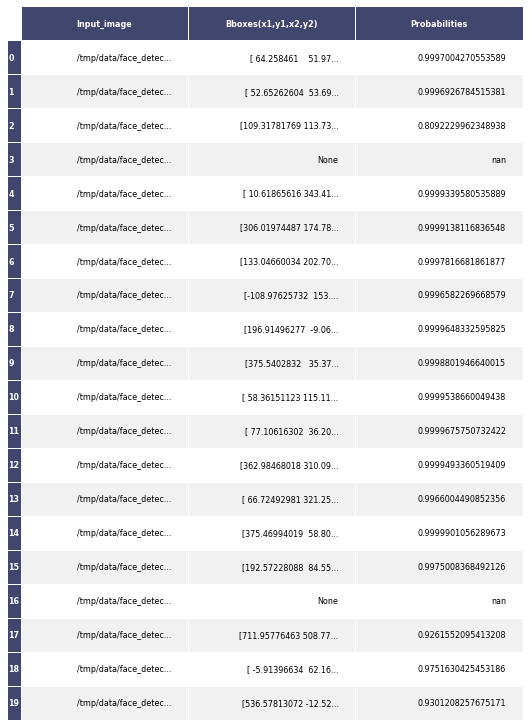

In [8]:
import matplotlib.pyplot as plt
from platiagro.plotting import plot_data_table

ax = plot_data_table(df)
plt.show()

## Mostrando alguns resultados obtidos

In [9]:
from draws import draw_bboxes
import numpy as np
from PIL import Image
import cv2

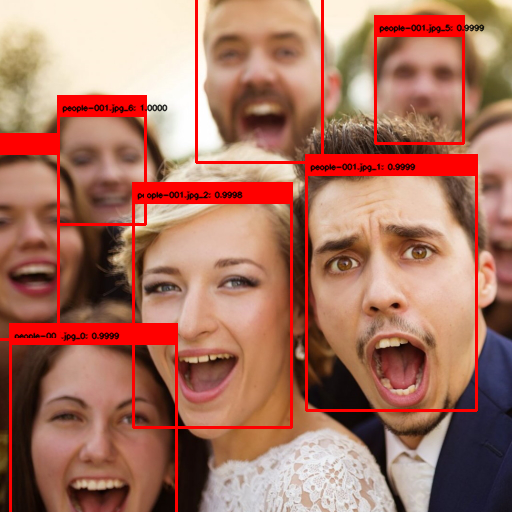

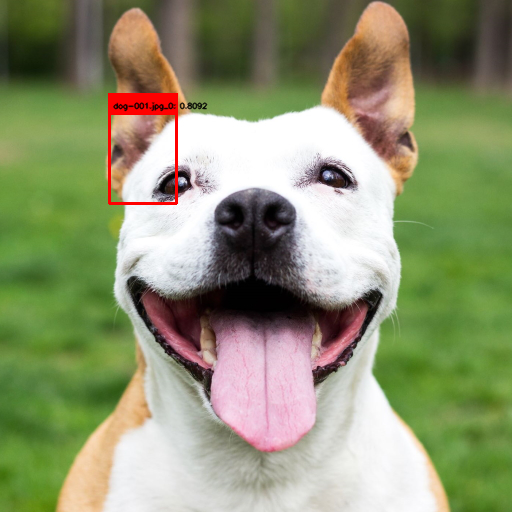

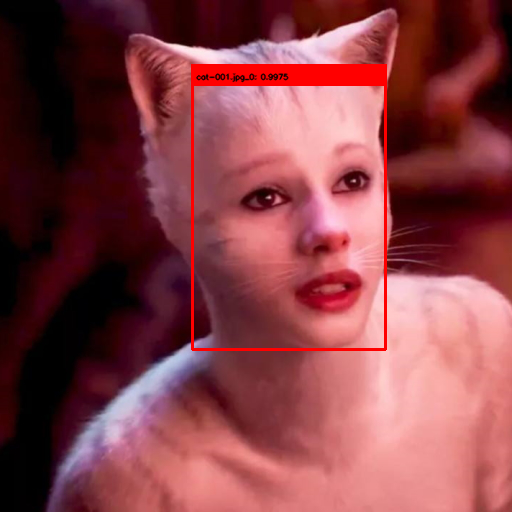

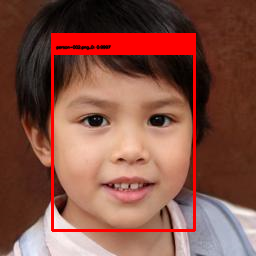

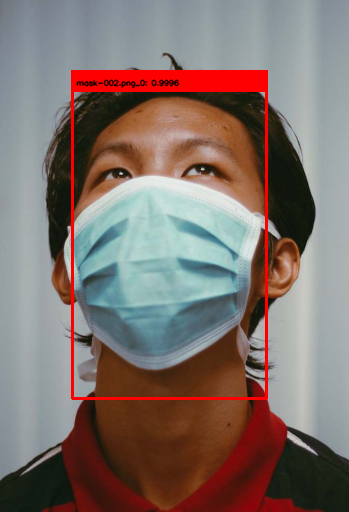

In [12]:
all_uniques = df.Input_image.unique()

# Select a sample of uniques
uniques = np.random.choice(all_uniques,  min(len(all_uniques), 5), replace=False)
for unique in uniques:
    bboxes = df[df['Input_image'] == unique]['Bboxes(x1,y1,x2,y2)'].values
    probs  = df[df['Input_image'] == unique]['Probabilities'].values
    
    if bboxes[0] is None: continue

    default_label = unique.split('/')[-1]
    labels = [f'{default_label}_{i}' for i in range(len(bboxes))]

    original_img = Image.open(unique).convert('RGB')
    img_arr      = np.array(original_img).astype(np.uint8)
    new_img = draw_bboxes(img_arr, bboxes, labels, probs)
    new_img = new_img.resize(original_img.size)
    
    new_img.show()

## Salva resultados da tarefa 

A plataforma guarda o conteúdo de `/tmp/data/` para as tarefas subsequentes.

In [12]:
# save dataset changes
dataset_path = folder + '_results.csv'
df.to_csv(dataset_path, index=False)

In [13]:
from joblib import dump

artifacts = {
    "model_parameters": model_parameters,
    "inference_parameters": inference_parameters

}

dump(artifacts, "/tmp/data/mtcnn.joblib")

['/tmp/data/mtcnn.joblib']